<a href="https://colab.research.google.com/github/litladeji/assignment/blob/main/Higgsing_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Know thy Higgs boson

**Background:** High-energy collisions at the Large Hadron Collider (LHC) produce particles that interact with particle detectors. One important task is to classify different types of collisions based on their physics content, allowing physicists to find patterns in the data and to potentially unravel new discoveries.

**Problem statement:** The discovery of the Higgs boson by CMS and ATLAS Collaborations was announced at CERN in 2012. In this work, we focus on the potential of Machine Learning and Deep Learning in detecting potential Higgs signal from one of the background processes that mimics it.

**Dataset:** The dataset is made available by the Center for Machine Learning and Intelligent Systems at University of California, Irvine. The dataset can be found on the [UCI Machine learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS)

**Description:** The dataset consists of a total of 11 million labeled samples of Higgs vs background events produced by Monte Carlo simulations. Each sample consists of 28 features. The first 21 features are kinematic properties measured at the level of the detectors. The last seven are functions of the first 21.

**Steps to load the training dataset**
1. **Download the dataset from the UCI website**

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2025-06-21 04:36:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [          <=>       ]   2.62G  5.34MB/s    in 10m 44s 

2025-06-21 04:47:31 (4.17 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



The above will create a file named `HIGGS.csv.gz`. Remember that in particle physics we deal with large amounts of data. In this case as well you have to be patient till the full file of `2.62 GB` data is downloaded. For a full analysis you might need to use the full dataset but for this exercise you can try with `10000` entries only

2. **Unzip the folder**

In [3]:
import pandas as pd

# gzip exceed the disk quota
data = pd.read_csv("HIGGS.csv.gz", compression='gzip', header=None, nrows=100000)

# Save to your working directory
data.to_csv("HIGGS.csv", index=False, header=False)


The above will create a `HIGGS.csv` file in your local directory. At this point you will see that the `HIGGS.csv.gz` file is unzipped as `HIGGS.csv` and got deleted after unzipping is complete.

3. **Load libraries**

If something is missing install them in the python environment

In [4]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import numpy as np
np.random.seed(42)  # for reproducibility
import h5py

from sklearn.metrics import roc_curve, auc

from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

import warnings


4. **Load the file using pandas library**

In [5]:
data=pd.read_csv('HIGGS.csv', header=None)
## print the first 5 rows
data.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. **Try to find the meaning of each of the variables from the datasource**

In [6]:
## change the column numbers to column names
data.columns = ['target',
              'lep_pT',
              'lep_eta',
              'lep_phi',
              'missE',
              'missphi',
              'jet1_pt',
              'jet1_eta',
              'jet_1_phi',
              'jet_1_b_tag',
              'jet_2_pt',
              'jet_2_eta',
              'jet_2_phi',
              'jet_2_b_tag',
              'jet_3_pt',
              'jet_3_eta',
              'jet_3_phi',
              'jet_3_b_tag',
              'jet_4_pt',
              'jet_4_eta',
              'jet_4_phi',
              'jet_4_b_tag',
              'm_jj',
              'm_jjj',
              'm_lv',
              'm_jlv',
              'm_bb',
              'm_wbb',
              'm_wwbb']

## print the first 5 rows (including the column names)
data.head()

,target,lep_pT,lep_eta,lep_phi,missE,missphi,jet1_pt,jet1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


Assign first column $0$ to class labels (labeled $1$ for signal, $0$ for background)  and all others to feature matrix $X$.

In this example, for the sake of fast checking, we use `10000` samples. To train on the entire dataset, proceed with uncommenting the lines below.

In [7]:
X=data.iloc[:10000,1:]#data.iloc[:,1:]
y=data.iloc[:10000,0]#data.iloc[:,0]

X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

5. **Visualize your data - One histogram per feature column**

Detailed information on what each feature column is can be found in *Attribute Information* section on the [UCI Machine learning Repositery](https://archive.ics.uci.edu/ml/datasets/HIGGS). For further information, refer to the [paper](https://www.nature.com/articles/ncomms5308) by Baldi et. al

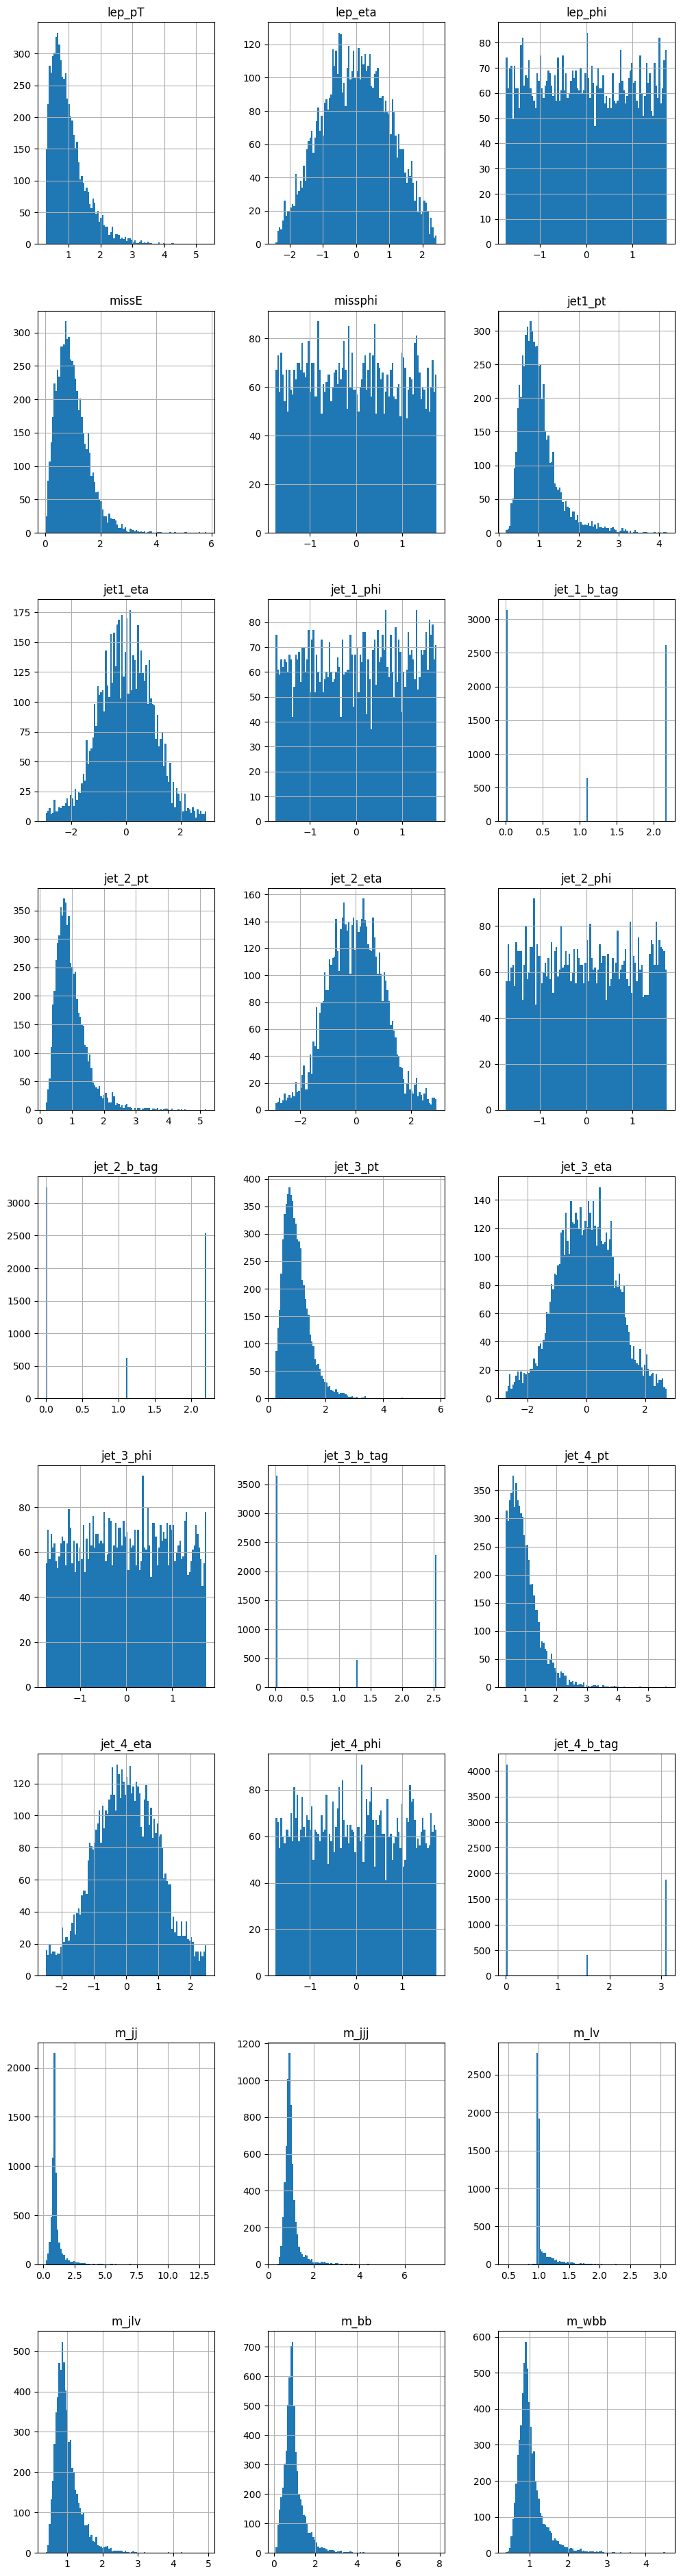

In [8]:
fig, axes = plt.subplots(len(X_train.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X_train.hist(column = X_train.columns[i], bins = 100, ax=axis)
        i = i+1

You can also visualise it through `pairplot`, but only select a few features at a time otherwise it would take a long time to produce the pairplot. In the following I have presented an example of pairplot. Use other features to see the pairplot.

<Figure size 2000x2000 with 0 Axes>

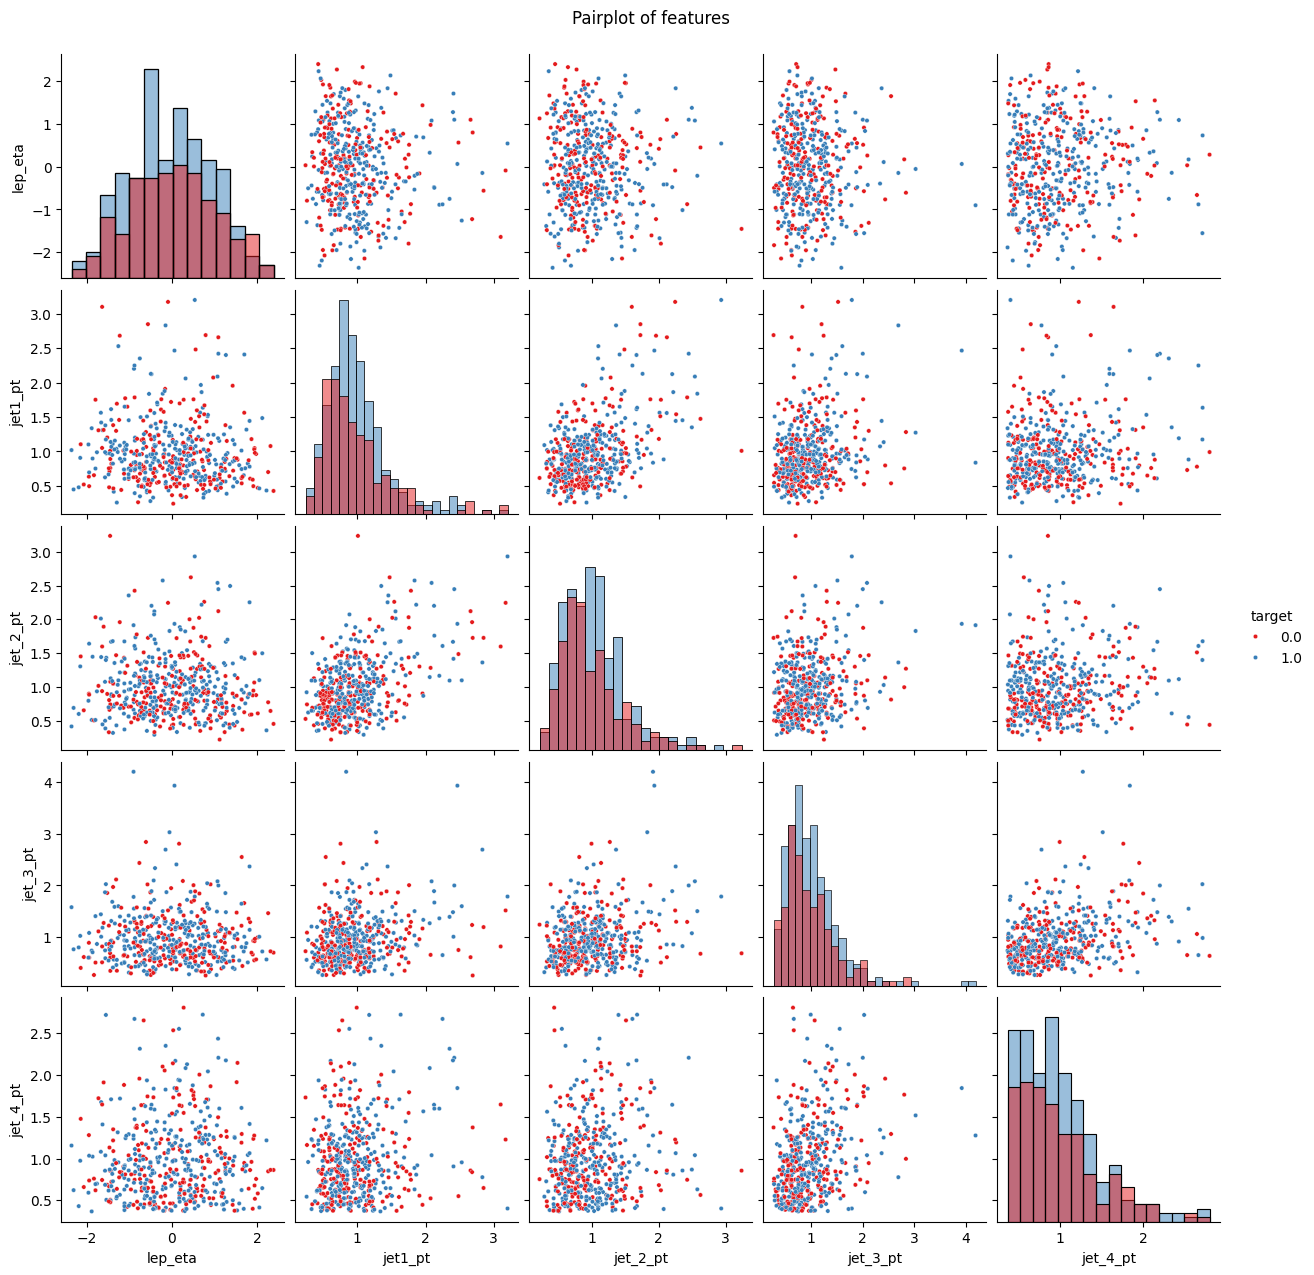

In [9]:
# Select only the eta and phi columns for leptons and jets, plus the target for classification
selected_columns = ['target',
              #'lep_pT',
              'lep_eta',
              #'lep_phi',
              #'missE',
              #'missphi',
              'jet1_pt',
              #'jet1_eta',
              #'jet_1_phi',
              #'jet_1_b_tag',
              'jet_2_pt',
              #'jet_2_eta',
              #'jet_2_phi',
              #'jet_2_b_tag',
              'jet_3_pt',
              #'jet_3_eta',
              #'jet_3_phi',
              #'jet_3_b_tag',
              'jet_4_pt',
              #'jet_4_eta',
              #'jet_4_phi',
              #'jet_4_b_tag',
              #'m_jj',
              #'m_jjj',
              #'m_lv',
              #'m_jlv',
              #'m_bb',
              #'m_wbb',
              #'m_wwbb'
              ]

# Select only those subset of the data
pairplot_data = data[:500][selected_columns] # only taking the first 5000 data points


plt.figure(figsize=(8, 8), dpi=250)
sns.pairplot(
    pairplot_data,
    hue="target",
    palette="Set1",
    diag_kind="hist",
    # Make dots smaller
    plot_kws={"s": 10},
)
plt.suptitle("Pairplot of features", y=1.02)
plt.show()

## **Setup the Boosted Decision Tree model**

Boosted Decision Trees are explaned here [here](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). This are what can be classified as `ensemble learning methods`, The main idea is to combine many weak learners (typically shallow decision trees) to create a strong classifier. In the following we will use **XGBoost = "Extreme Gradient Boosting"** package.

For each round (up to `n_estimators`):
1. **Compute Gradient (error/loss derivative):** Measures how wrong the current prediction is using the weak learners with `max_depth`. This sets the maximum depth of each individual decision tree (not the number of trees).

- A tree of depth $3$ has at most $2^3 = 8$ leaf nodes.
- It controls the complexity of each tree:
    - Smaller depth → simpler trees, less overfitting.
    - Larger depth → more complex trees, more capacity, but risk of overfitting.

**Intuition:** If each tree is a `correction rule`, `max_depth` limits how detailed each rule can be.

2. **Fit a New Tree:** A decision tree is trained to predict the gradient (residual) of the loss function.

3. **Update Predictions:** Add the tree’s output to the model’s prediction (with some scaling factor: learning_rate).

4. **Regularization:** Penalize complex trees to avoid overfitting (e.g., with max_depth, min_child_weight, gamma).




In [10]:
classifier = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'  # or 'mlogloss' for multi-class
)

In [11]:
warnings.filterwarnings("ignore") # I am suppressing some warning, but you can let it run
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Now it is the time to predict the class using the classifier and see how it performs.

**Objective: Improve the model accuracy**

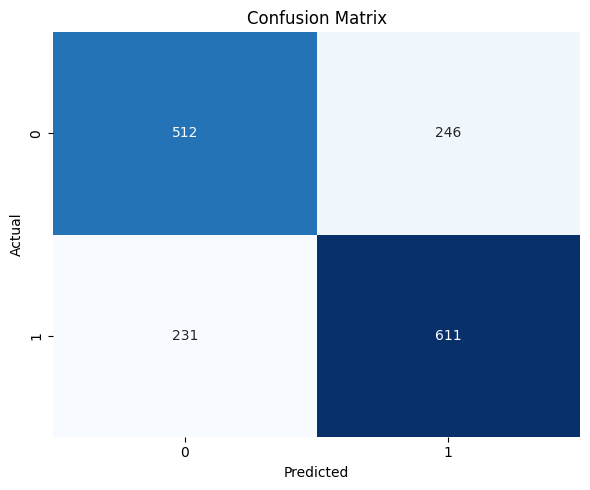

Accuracy  : 0.7019
Precision : 0.7130
Recall    : 0.7257
F1 Score  : 0.7192


In [12]:
# Make predictions
predictions = classifier.predict(X_test)

# Confusion Matrix, but this time using seaborn
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Compute and print scores
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, average='binary')
rec = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

## Setup the neural network model

**Objective:** Use pytorch to build a network to predict the classes and compare that with bossted tree output.

**Hints:**
- you might want to use the Binary cross entropy loss.

In [13]:
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [14]:
import torch
from sklearn.model_selection import train_test_split

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


In [15]:
import torch.nn as nn
import torch.optim as optim

input_dim = X_train.shape[1]

class HiggsNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = HiggsNet(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.7047
Epoch 5, Loss: 0.6940
Epoch 10, Loss: 0.6929
Epoch 15, Loss: 0.6916


In [18]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy().flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)


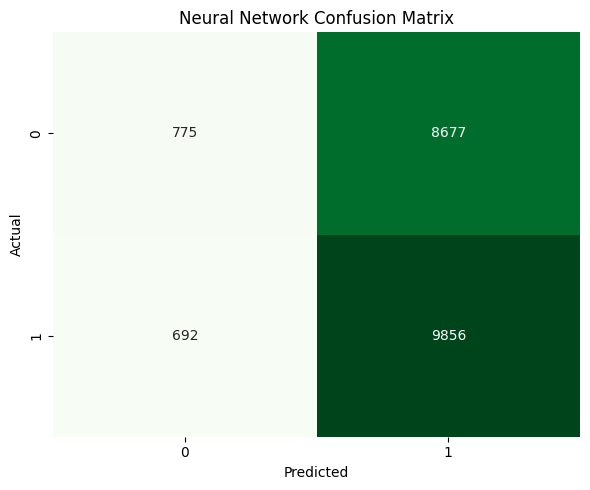

Accuracy  : 0.5315
Precision : 0.5318
Recall    : 0.9344
F1 Score  : 0.6778


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

cm_nn = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.tight_layout()
plt.show()

print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score  : {f1_score(y_test, y_pred):.4f}")


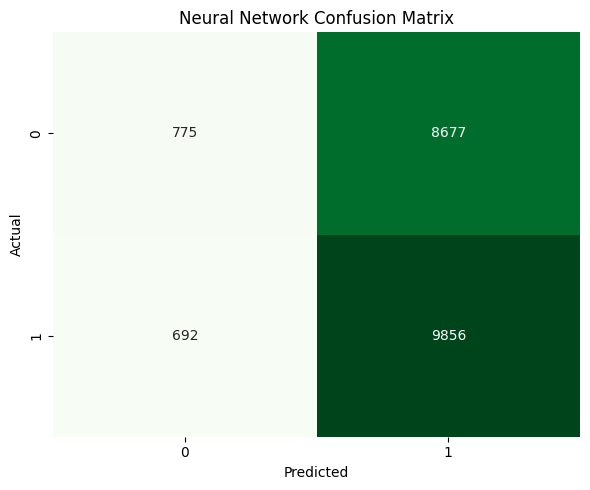

Accuracy  : 0.5315
Precision : 0.5318
Recall    : 0.9344
F1 Score  : 0.6778


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

cm_nn = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.tight_layout()
plt.show()

print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score  : {f1_score(y_test, y_pred):.4f}")
